➡️**translation models**:
* Helsinki-NLP/opus-mt-de-en ✔️
* Helsinki-NLP/opus-mt-es-en ✔️
* Helsinki-NLP/opus-mt-pl-en ✔️
* Helsinki-NLP/opus-mt-tr-en ✔️
* Helsinki-NLP/opus-mt-fr-en ✔️
* Helsinki-NLP/opus-mt-ar-en ✔️

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet transformers
!pip install --quiet sentencepiece
!pip install --quiet datasets

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from tqdm.notebook import tqdm
from collections import defaultdict

import json
import re
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import transformers
# import nlp
# from torch.utils.data import Dataset
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import logging
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

tqdm.pandas()

In [ ]:
WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))
def truncate_newline(text):
  # remove double new-line character
  text = text.replace("\n\n", " ")
  return text

# download JSON based file in dictionary format
def get_json(path_to_file):
  with open(path_to_file, 'r') as openfile:
      articles = json.load(openfile)
  return articles

# accepts preprocessed text
# generate list of sentences -> document
def generate_doc(text, lang="german"):
  de_tokenizer = nltk.data.load(f'tokenizers/punkt/{lang}.pickle')
  document = de_tokenizer.tokenize(text)
  document = [sentence.strip('.') for sentence in document]
  return document

# partition document based on max_words
def doc_partitioning_using_tokenizer(document, tokenizer: transformers.AutoTokenizer, max_tokens = 150):
  processed_dict = dict()
  processed_dict['part_0'] = ''
  identity_generator = 'part_'
  temp = ''
  count = 0
  for sentence in document:
    key = f'{identity_generator}{count}'
    temp = temp + sentence
    n_tok = len(tokenizer.encode(
        temp
    ))
    if n_tok > max_tokens:
      temp = ''
      count += 1
      key = f'{identity_generator}{count}'
      processed_dict[key] = ''
    processed_dict[key] = processed_dict[key] + '. ' + sentence
  return processed_dict

# interject 2 dataframes
def intersect_data(partitioned_data: dict, index: int, orig_df: pd.DataFrame):
  length = len(partitioned_data)                                       
  indices = [index] * length                                     
  processed_chunks = partitioned_data.values()
  generated_dict = {
      'id': indices,
      'text': processed_chunks
  }
  temp_df = pd.DataFrame(generated_dict) 
  # append at the end of original dict
  orig_df = orig_df.append(temp_df, ignore_index=True)        
  return orig_df

# batched processing to generate final dataframe
def batch_process(data: pd.DataFrame, tokenizer: transformers.AutoTokenizer):
  chunked_data = pd.DataFrame(columns=['id', 'text']) 
  for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    # get document(text) & index
    document = row['text']    
    index = row['id']       
    document = generate_doc(truncate_newline(document), lang="german")                      
    document_chunks = doc_partitioning_using_tokenizer(document, tokenizer)
    chunked_data = intersect_data(document_chunks, index, chunked_data)
  return chunked_data

# translation module.
def process_chunks(processed_dict: dict, tokenizer: transformers.AutoTokenizer, model: transformers.AutoModel):
  translated_doc = dict()
  # loop over document chunks to generate translations 
  for key in processed_dict.keys():
    # get input_ids
    encodings = tokenizer(
        [WHITESPACE_HANDLER(processed_dict[key])],
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=512,
    )
    # print(torch.count_nonzero(encodings['attention_mask']))
    # generate output
    output_ids = model.generate(
        input_ids=encodings['input_ids'],
        no_repeat_ngram_size=2,
        num_beams=4
    )[0]
    # generate translated version of text
    translated_text = tokenizer.decode(
        output_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )
    translated_doc[key] = translated_text
  return translated_doc

# join translated dict
def join_translated_text(translated_dict: dict):
  translated_document = ''
  for key in translated_dict.keys():
    translated_document += translated_dict[key]
  return translated_document

# process data : required type -> dataframe
def process_dataframe(model_name, data: pd.DataFrame):
  tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)  
  model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_name)

  TRANSLATED_DATA = dict()

  for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    text = row['text']    # get text
    idx = row['id']       # get document index
    document = generate_doc(truncate_newline(text), lang="german")                      
    document_chunks = doc_partitioning_using_tokenizer(document, tokenizer)
    translated_dict = process_chunks(document_chunks, tokenizer, model)
    # append the text to TRANSLATED_DATA (dict)
    TRANSLATED_DATA[f'{idx}'] =  join_translated_text(translated_dict)

  return data

# tokenization
max_length = 512
def convert_to_features(example_batch):
    features = tokenizer.batch_encode_plus(
        example_batch['text'], max_length=max_length, pad_to_max_length=True
    )
    features["id"] = example_batch["id"]
    return features

# aggregation
def zip_id2text(data: pd.DataFrame):
  data_dict = data.to_dict()
  indices = list(data_dict['id'].values())
  texts = list(data_dict['text'].values())
  # default dict to store translated sentences corresponding to the respective id
  DICT = defaultdict(list) 
  for index, text in zip(indices, texts):
    DICT[index].append(text)
  # convert list to paragraphs
  new_dict = dict((key, " ".join(value)) for key, value in DICT.items())
  return new_dict

# save dict -> json
def to_json(save_location, file_name, dict_: dict):
  try:
    with open(f'{save_location}/{file_name}', 'w') as fp:
      json.dump(dict_, fp)
    return True 
  except Exception as e:
    return False

# merge 2 dictionaries of varied length
def merge_dictionaries(a, b):
   return {**a, **b}

In [ ]:
### INITIALIZE MODEL
# sample language, de, pl, tr, en, fr, es, ru, zh, ar
language = 'de'
model_name = f"Helsinki-NLP/opus-mt-{language}-en"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_name)

----
#### Translation

In [ ]:
# # load original semeval data version - 2
# path_to_file = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/json_text_extract_v2.csv"
# json_df = pd.read_csv(path_to_file)

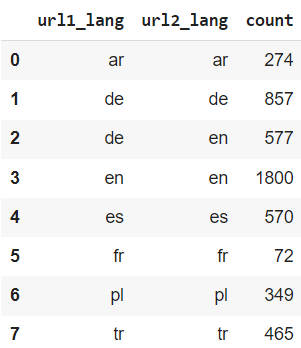

In [ ]:
# # get data
# polish_df = json_df[json_df['lang'] == 'pl']
# # spanish_df.dropna(inplace=True)
# # spanish_df.isna().sum()
# polish_df = polish_df.dropna()
# print(f'shape of the dataframe: {polish_df.shape}')

In [ ]:
# ### IMPLEMENTATION
# chunks_doc_df = batch_process(polish_df, tokenizer)

# # removing empty elements 
# chunks_doc_df.replace('', float('NaN'), inplace=True)
# chunks_doc_df.dropna(inplace=True)
# chunks_doc_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/chunks_doc_pl.csv", index=False)

# # tokenization using huggingface dataset
# path_to_file = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/chunks_doc_pl.csv"
# pl_dataset = load_dataset('csv', data_files={
#     "train": path_to_file
# })

# # apply tokenization on dataset
# features_dict = {}
# features_dict = pl_dataset.map(
#     convert_to_features,
#     batched=True,
#     load_from_cache_file=False
# )

# # convert features into torch.Tensor
# features_dict.set_format(
#     type="torch",
#     columns=["input_ids", "attention_mask", "id"]
# )

In [ ]:
# # apply translation model to chunked documents saved in dataframe
# output_dict = { 'id': [], 'text': [] }
# path_to_save_loc = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/trans_doc_pl.csv"

# count = 0
# for item in tqdm(features_dict['train']):
#   output_ids = model.generate(
#       input_ids=item['input_ids'].unsqueeze(0),
#       no_repeat_ngram_size=2,
#       num_beams=4,
#   )[0]

#   translated_text = tokenizer.decode(
#       output_ids,
#       skip_special_tokens=True,
#       clean_up_tokenization_spaces=False
#   )

#   output_dict['id'].append(item['id'].item()) 
#   output_dict['text'].append(translated_text)

#   count += 1
#   if count % 100 == 0:
#     translated_data = pd.DataFrame(output_dict)
#     translated_data.to_csv(path_to_save_loc, index=False)

# translated_data = pd.DataFrame(output_dict)
# translated_data.to_csv(path_to_save_loc, index=False)

--------
#### Unprocessed data

In [ ]:
# # get remaining unprocessed document chunks
# remains_df = chunks_doc_df.loc[8200:]

In [ ]:
# remains_df.sample(3)

,id,text
8241,1636299501,". Breitengrad einziehen soll, was ein eklatant..."
8227,1626299587,". Zugegriffen: Mai 2020. van der Heijde D, et ..."
8235,1483973708,. Die Klimapolitik der Bundesregierung mag ja ...


In [ ]:
# remains_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/remains_de.csv", index=False)

In [ ]:
# ### IMPLEMENTATION
# path_to_file = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/de.csv"
# de_dataset = load_dataset('csv', data_files={
#     "train": path_to_file
# })

# # apply tokenization on dataset
# features_dict = {}
# features_dict = de_dataset.map(
#     convert_to_features,
#     batched=True,
#     load_from_cache_file=False
# )

# # convert features into torch.Tensor
# features_dict.set_format(
#     type="torch",
#     columns=["input_ids", "attention_mask", "id"]
# )

In [ ]:
# output_dict = { 'id': [], 'text': [] }

# count = 0
# for item in tqdm(features_dict['train']):
#   output_ids = model.generate(
#       input_ids=item['input_ids'].unsqueeze(0),
#       no_repeat_ngram_size=2,
#       num_beams=4,
#   )[0]

#   translated_text = tokenizer.decode(
#       output_ids,
#       skip_special_tokens=True,
#       clean_up_tokenization_spaces=False
#   )

#   output_dict['id'].append(item['id'].item())
#   output_dict['text'].append(translated_text)

In [ ]:
# trans_doc_df_part2 = pd.DataFrame(output_dict)

In [ ]:
# path_to_save_loc = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/part_2.csv"
# trans_doc_df_part2.to_csv(path_to_save_loc, index=False)

-----
#### Postprocessing and concatenation

In [ ]:
# # main translated data
# path_to_chunked_docs = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test/text/chunks_doc_fr.csv"
# path_to_translated_chunked_docs = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test/text/trans_text_fr.csv" 
# chunks_doc_df = pd.read_csv(path_to_chunked_docs)
# trans_doc_df = pd.read_csv(path_to_translated_chunked_docs)
# chunks_doc_df.shape, trans_doc_df.shape

In [ ]:
# # late translated data
# path_to_late_chunked_docs = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test/text/to_be_trans/chunks_doc_fr.csv"
# path_to_late_translated_chunked_docs = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test/text/to_be_trans/trans_text_fr.csv" 
# late_chunks_doc_df = pd.read_csv(path_to_late_chunked_docs)
# late_trans_doc_df = pd.read_csv(path_to_late_translated_chunked_docs)
# late_chunks_doc_df.shape, late_trans_doc_df.shape

In [ ]:
# final_chunks_doc_df = pd.concat([chunks_doc_df, late_chunks_doc_df], axis=0)
# final_trans_doc_df = pd.concat([trans_doc_df, late_trans_doc_df], axis=0)
# final_chunks_doc_df.shape, final_trans_doc_df.shape

In [ ]:
# !mkdir "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/"

In [ ]:
# final_trans_doc_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/trans_doc_fr.csv", index=False)
# final_chunks_doc_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/chunks_doc_fr.csv", index=False)

In [ ]:
# # post processing 
# path_to_dir = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/"
# de_trans_1 = pd.read_csv(f"{path_to_dir}part_1.csv")
# de_trans_2 = pd.read_csv(f"{path_to_dir}part_2.csv")
# print(de_trans_1.shape, de_trans_2.shape)
# trans_doc_df = pd.concat([de_trans_1, de_trans_2], axis=0)
# trans_doc_df.reset_index(drop=True, inplace=True)
# trans_doc_df.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/trans_doc_de.csv", index=False)

In [ ]:
# removal_ids = [1588378112, 1484428859, 1626260724, 1483972876, 1484045655]
# removal_indices = []
# for index in removal_ids:
#   removal_indices.extend(list(trans_doc_df[trans_doc_df['id'] == index].index))

# # manually searched keep ids
# keep_indices = [331, 332, 339, 343, 348, 352, 357, 400, 407, 428, 435, 505, 660, 661, 663, 1629, 1630, 7873, 7874, 7876, 7877, 7881, 7884, 7888, 7889, 7892, 7896, 7904, 7916, 7920, 7940, 7941, 7950, 7953, 1251, 1252, 1009, 1010, 1011]

# # final removal list
# final_remove_indices = [remove_index for remove_index in removal_indices if remove_index not in keep_indices]

# # remove unnecessary element from both the data frames
# trans_doc_df.drop(index=trans_doc_df.index[final_remove_indices], inplace=True)
# chunks_doc_df.drop(index=chunks_doc_df.index[final_remove_indices], inplace=True)

# # save to location
# trans_doc_df.to_csv(path_to_translated_chunked_docs, index=False)
# chunks_doc_df.to_csv(path_to_chunked_docs, index=False)

------

In [ ]:
trans_doc_df = pd.read_csv(f'{path_to_dir}trans_doc_en.csv')
DICT = zip_id2text(trans_doc_df)

In [ ]:
trans_doc_df.head()

,id,title
0,1607032624,Aerolineas Argentinas brings back medical supp...
1,1506242721,"Coronavirus live updates: More than 182,000 pe..."
2,1571951376,Taliban suspend talks with Afghan govt for pri...
3,1571753639,Sony DualSense PlayStation 5 Controller Finall...
4,1615981957,Brian May says he was 'very near death' after ...


In [ ]:
# convert translated chunks to aggregated docs w.r.t 'id'
DICT = zip_id2text(final_trans_doc_df)
# # save processed dictionary (JSON)
save_location = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/"
file_name = "translated_french_test_data.json"
to_json(save_location, file_name, DICT)

True

In [ ]:
len(DICT)

447

-----
#### Processing engish data

In [ ]:
# json_extract
json_df = pd.read_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/json_text_extract_test.csv")
json_df.head(3)

,id,lang,link,title,text,meta_description,description,extra_text
0,1544911607,it,http://www.cittadellaspezia.com/La-Spezia/Poli...,"Coronavirus, Rixi: ""No a mezze misure: chiusur...",La Spezia - “La chiusura totale di tutte le at...,Città della Spezia - “La chiusura totale di tu...,“La chiusura totale di tutte le attivit&#224; ...,Città della Spezia - “La chiusura totale di tu...
1,1643452007,zh,http://baobinhduong.vn/cn/越南承诺同各国努力为武装冲突中的儿童带来...,越南承诺同各国努力为武装冲突中的儿童带来积极的改变,2020-06-24 17:46\n\n越南常驻联合国代表团团长邓廷贵大使。（图片来源：越通...,NaN,联合国安理会6月23日召开题为“儿童与武装冲突”的视频辩论会，旨在评估侵犯儿童行为的情况以及...,联合国安理会6月23日召开题为“儿童与武装冲突”的视频辩论会，旨在评估侵犯儿童行为的情况以及...
2,1538363190,ar,https://www.emaratalyoum.com/politics/news/202...,"مصر تحظر دخول القطريين عملاً بـ""المعاملة بالمث...",المصدر: متابعات – الإمارات اليوم\n\nعقد مجلس ا...,عقد مجلس الوزراء المصري اجتماعه اليوم، برئاسة ...,عقد مجلس الوزراء المصري اجتماعه اليوم، برئاسة ...,عقد مجلس الوزراء المصري اجتماعه اليوم، برئاسة ...


In [ ]:
chunks_english_df = json_df[json_df['lang'] == 'en']
# drop extra columns 
chunks_english_df.drop(['lang', 'link', 'meta_description', 'description'], axis=1, inplace=True)  
chunks_english_df.head(3)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,title,text,extra_text
15,1607032624,Aerolineas Argentinas brings back medical supp...,"Today (April 15), an Airbus A330-200 of Aeroli...","Today (April 15), an Airbus A330-200 of Aeroli..."
16,1506242721,"Coronavirus live updates: More than 182,000 pe...","The coronavirus that originated in Wuhan, Chin...",The World Health Organization has declared the...
18,1571951376,Taliban suspend talks with Afghan govt for pri...,Taliban suspend talks with Afghan govt for pri...,PESHAWAR: The Afghan peace process suffered an...


In [ ]:
title_en =  chunks_english_df[['id', 'title']]
title_en.sample(3)

,id,title
1109,1579452741,Leveraging Technology to Prevent Pandemics
6735,1488314513,Newsroom
439,1484035283,One of the NY Hanukkah stabbing victims may no...


In [ ]:
extra_text_en = chunks_english_df[['id', 'extra_text']]
extra_text_en.sample(3)

,id,extra_text
3299,1599558858,"Anheuser-Busch InBev, the world's largest beer..."
5304,1543410122,A SARS-like virus has claimed 17 lives since e...
3230,1594077375,Lyon president Jean-Michel Aulas says the club...


In [ ]:
chunks_doc_en = chunks_english_df[['id', 'text']]
chunks_doc_en.sample(3)

,id,text
5022,1553260461,"Guayaquil, March 19 (RHC)-- Guayaquil authorit..."
4389,1625456558,"Acting King Azenathi Dalindyebo, his mother an..."
4445,1505469635,President Trump told his national security adv...


In [ ]:
chunks_doc_en.to_csv('/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/trans_doc_en.csv', index=False)
extra_text_en.to_csv('/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/title_en.csv', index=False)
title_en.to_csv('/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/extra_text_en.csv', index=False)

In [ ]:
# convert translated chunks to aggregated docs w.r.t 'id'
DICT = zip_id2text(chunks_doc_en)
# # save processed dictionary (JSON)
save_location = "/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/translation_data/test_merged/"
file_name = "translated_english_test_data.json"
to_json(save_location, file_name, DICT)

True